第幾張圖片對應到什麼角色部件: {1: 'face', 2: 'hair', 3: 'eye', 4: 'eye'}
角色部件對應的顏色值： {'face': [253, 224, 201], 'hair': [129, 97, 103], 'eye': [6, 50, 85]}


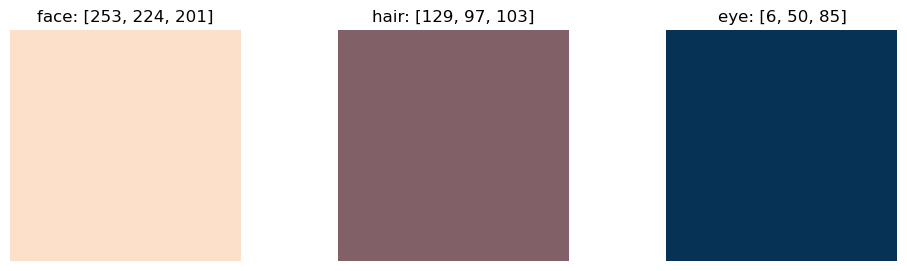

角色部件對應的可上色座標： {'face': ['(198, 216)'], 'hair': ['(207, 65)', '(139, 67)'], 'eye': ['(144, 239)', '(247, 232)']}


In [10]:
import os
import glob
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2 as cv

# 讀取CHD segment txt檔案到字典
def read_files_to_dict(directory, base_filename, start_index=1):
    result_dict = {}
    index = start_index
    while True:
        file_path = os.path.join(directory, f"{base_filename}_{index}_output.txt")
        
        if not os.path.isfile(file_path):
            break
        
        with open(file_path, 'r', encoding='utf-8') as file:
            first_line = file.readline().strip()
            first_line_split = first_line.split(':', 1)
            result = first_line_split[1].strip() if len(first_line_split) > 1 else None
            
            # 獲取結果描述
            final_result = result.split()[1] if result else None
            result_dict[index] = final_result
        
        index += 1
    
    return result_dict  # 第幾張圖片對應到什麼角色部件的字典

# 讀取segment CHD
def load_images(directory, base_filename):
    image_files = glob.glob(os.path.join(directory, f"{base_filename}_*.png"))
    images = [Image.open(image_file) for image_file in sorted(image_files)]
    return images

# 獲取第二主要顏色(利用kmeans取色)
def get_second_dominant_color(image, k=4):
    img_np = np.array(image)
    img_np = img_np.reshape((-1, 3))
    
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_np)
    
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    sorted_indices = np.argsort(counts)
    
    second_dominant_color = kmeans.cluster_centers_[unique[sorted_indices[-2]]]
    return second_dominant_color.astype(int)

# 設置目錄和基礎文件名
directory = './output/CHD'
base_filename = 'segment'

# 讀取結果字典和圖像
result_dict = read_files_to_dict(directory, base_filename)
images = load_images(directory, base_filename)

# 獲取每張圖片的第二主要顏色
second_dominant_colors = {str(i+1): get_second_dominant_color(img).tolist() for i, img in enumerate(images)}

# 合併結果字典和顏色字典
combined_dict = {result_dict[key]: second_dominant_colors[str(key)] for key in result_dict}
print("第幾張圖片對應到什麼角色部件:", result_dict)
print("角色部件對應的顏色值：", combined_dict)

# 顯示顏色預覽
def show_color_previews(color_dict):
    fig, axs = plt.subplots(1, len(color_dict), figsize=(12, 3))
    for ax, (title, color) in zip(axs, color_dict.items()):
        color_array = np.array(color) / 255.0
        ax.imshow([[color_array]])
        ax.set_title(f'{title}: {color}')
        ax.axis('off')
    plt.show()

show_color_previews(combined_dict)

# 讀取位置檔案並更新字典
def process_file_with_cleaned_keys(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        if lines:
            key = lines[0].split(" ", 1)[1].strip() if len(lines[0].split(" ", 1)) > 1 else None #使用 split(" ", 1) 將第一行拆分為两部分，並獲取空格后的字符串作為關鍵字
            coords = [line.split(": ")[-1].strip() for line in lines[2:] if line.startswith('點')]
            #從第三行開始（跳過第二行），逐行檢查，如果以 點 開頭，則提取後面的座標值。
            #使用 split(": ")[-1].strip() 來獲取冒号後面的部分並去除首尾空白字符。
            return key, coords
    return None, None

# 讀取位置檔案並更新字典
def read_position_files(file_paths):
    position_dict = {}
    for file_path in file_paths:
        key, coords = process_file_with_cleaned_keys(file_path)
        if key and coords:
            position_dict[key] = coords
    return position_dict

# 位置檔案路徑
file_paths = glob.glob("./output/CHS/segment_*.txt")
position_dict = read_position_files(file_paths)
print("角色部件對應的可上色座標：", position_dict)

# 填充顏色並顯示(floodfill)
def fill_color_demo(sketch, color_dictionary, position_dictionary):
    copy_img = sketch.copy()
    h, w = sketch.shape[:2]
    mask = np.zeros([h+2, w+2], np.uint8)
    
    for key, position_list in position_dictionary.items():
        if key in color_dictionary:
            rgb = color_dictionary[key]
            r, g, b = rgb
            for position_str in position_list:
                x, y = map(int, position_str.strip('()').split(', '))
                cv.floodFill(copy_img, mask, (x, y), (int(b), int(g), int(r)), (100, 100, 100), (100, 100, 100), cv.FLOODFILL_FIXED_RANGE)
    
    # 修改圖片在螢幕中顯示的大小
    screen_res = 1920, 1080  # 假設我的電腦螢幕顯示尺寸
    scale_width = screen_res[0] / w
    scale_height = screen_res[1] / h
    scale = 0.7
    window_width = int(w * scale)
    window_height = int(h * scale)
    
    cv.namedWindow("Filled Sketch", cv.WINDOW_NORMAL)
    cv.resizeWindow("Filled Sketch", window_width, window_height)
    cv.imshow("Filled Sketch", copy_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

image_path = "142_CHS1.png"
sketch = cv.imread(image_path)
fill_color_demo(sketch, combined_dict, position_dict)
